 Max error: 5.872452809363438e-06
 L2 error:  4.1525780077903014e-06


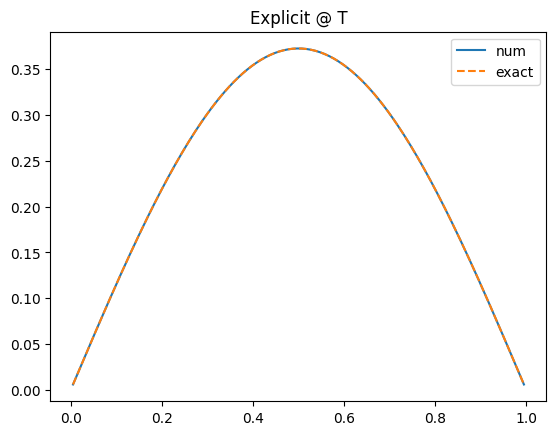

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L, α = 1.0, 1.0
N = 200
T = 0.1
dx = L/(N+1)
x = np.linspace(dx, L-dx, N)
dt = 0.5 * dx*dx/α   # choose dt = 0.5*dx^2/α for stability (λ=0.5)
λ = α*dt/dx**2
steps = int(T/dt)

# Initial data
u = np.sin(np.pi*x)
u_new = np.empty_like(u)

for n in range(steps):
    # interior update
    u_new[0]   = u[0]   + λ*(0      - 2*u[0]   + u[1])
    u_new[-1]  = u[-1]  + λ*(u[-2] - 2*u[-1]  + 0)
    u_new[1:-1]= u[1:-1]+ λ*(u[0:-2] - 2*u[1:-1] + u[2:  ])
    u, u_new = u_new, u

# exact and error
u_ex = np.sin(np.pi*x)*np.exp(-α*np.pi**2*T)
err   = u - u_ex

print(" Max error:", np.max(np.abs(err)))
print(" L2 error: ", np.sqrt(dx)*np.linalg.norm(err))

plt.figure(); plt.plot(x,u,'-',x,u_ex,'--'); plt.legend(['num','exact'])
plt.title("Explicit @ T"); plt.show()


In [ ]:







Ok so the one below uses some spectral methods to solve the PDEs


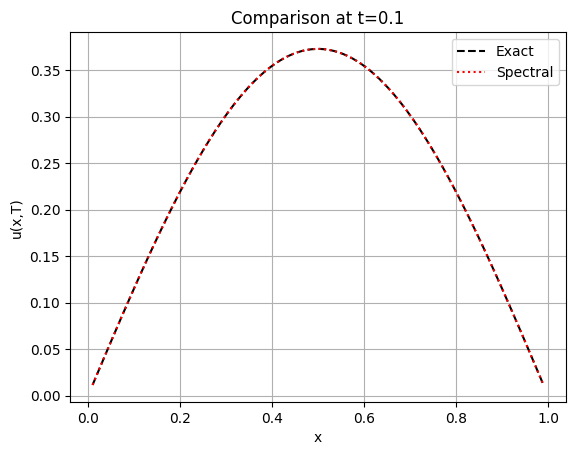

In [6]:
import numpy as np
import matplotlib.pyplot as plt
L,alpha= 1.0,1.0
N=100
T=0.1
dx=L/(N+1)
x=np.linspace(dx,L-dx,N)
u0=np.sin(np.pi*x);
diag=np.full(N,2.0/dx**2)
off=np.full(N-1, -1/dx**2)
A = np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)

eigvals, eigvecs = np.linalg.eigh(A)
coeffs = eigvecs.T @ u0                       # project onto eigenmodes
u_spec = eigvecs @ (coeffs * np.exp(-alpha * eigvals * T))

u_exact = np.sin(np.pi * x) * np.exp(-alpha * np.pi**2 * T)


plt.figure()
plt.plot(x, u_exact, 'k--', label='Exact')
plt.plot(x,u_spec, 'r:', label='Spectral')
plt.grid(True)
plt.legend()
plt.xlabel('x'); plt.ylabel('u(x,T)')
plt.title(f"Comparison at t={T}")
plt.show()

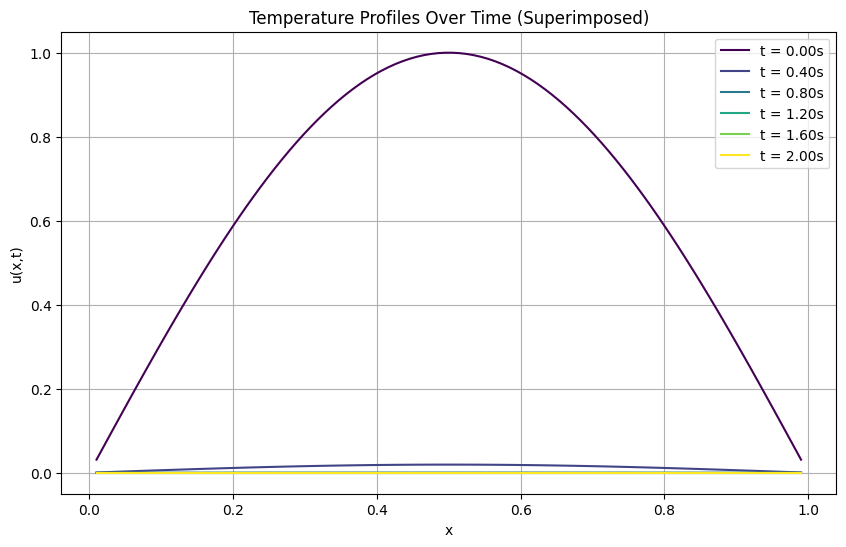

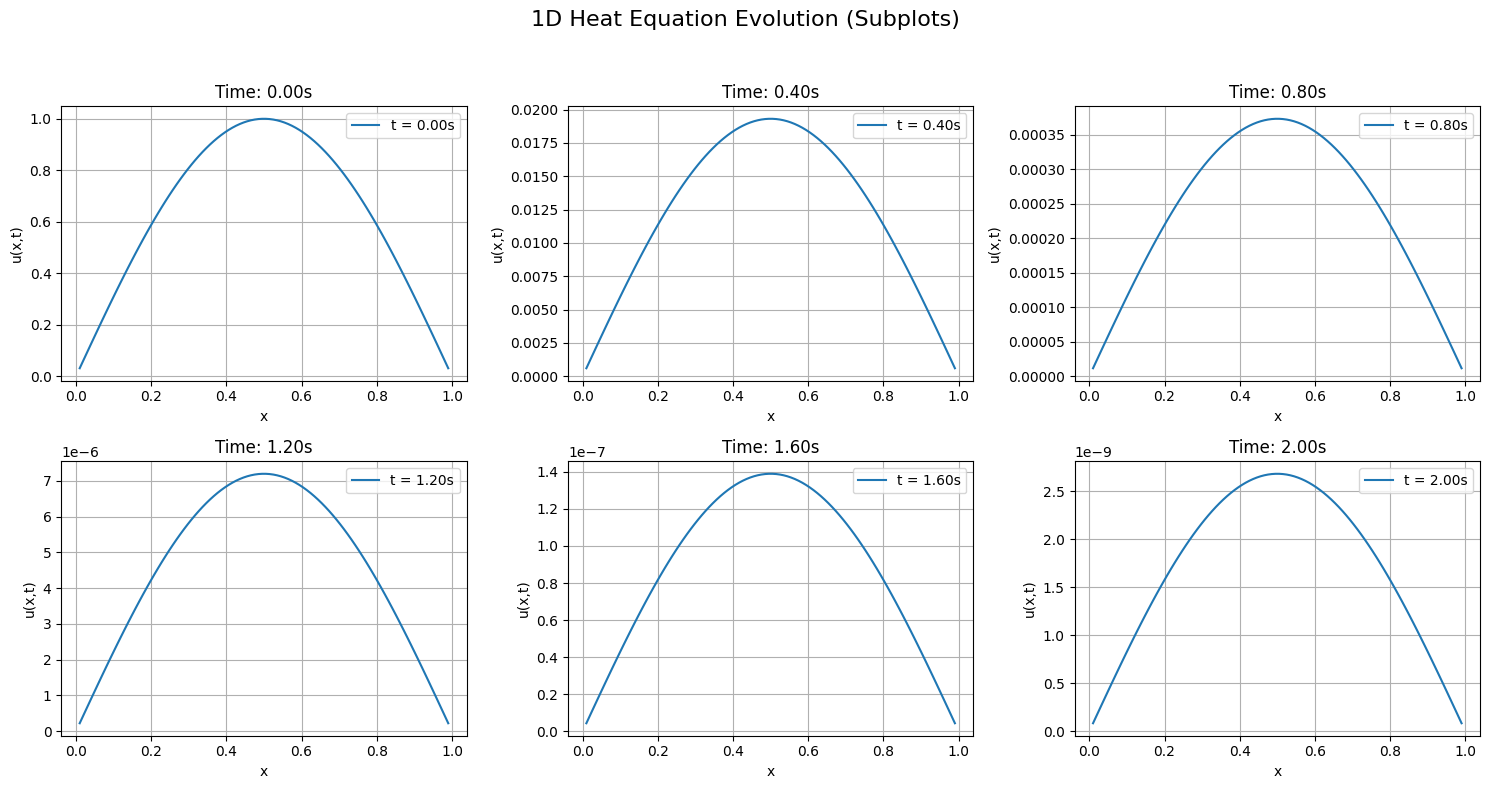

In [20]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Parameters
L = 1.0
T = 2
alpha = 1.0
N = 100
dx = L / (N + 1)
dt = 1e-5
r = alpha * dt / dx**2
x = np.linspace(dx, L - dx, N)
num_steps = int(T / dt)

# Construct A and M
main_diag = -2 * np.ones(N)
off_diag = np.ones(N - 1)
A = sp.diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csr')
I = sp.eye(N, format='csr')
M = I - r * A

# Initial condition
u0 = np.sin(np.pi * x)
u = u0.copy()
u_snapshots = [u.copy()]

# Snapshot timing
num_plots = 6
snap_interval = num_steps // (num_plots - 1)

# Time stepping + storing snapshots
for i in range(1, num_steps + 1):
    u = spla.spsolve(M, u)
    if i % snap_interval == 0:
        u_snapshots.append(u.copy())

# === Superimposed Plot ===
plt.figure(figsize=(10, 6))
colors = cm.viridis(np.linspace(0, 1, len(u_snapshots)))

for idx, (u_snap, color) in enumerate(zip(u_snapshots, colors)):
    t = idx * snap_interval * dt
    plt.plot(x, u_snap, color=color, label=f't = {t:.2f}s')

plt.title("Temperature Profiles Over Time (Superimposed)")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid(True)
plt.show()

# === Optional: Keep subplots too ===
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, ax in enumerate(axes):
    t = idx * snap_interval * dt
    ax.plot(x, u_snapshots[idx], label=f't = {t:.2f}s')
    ax.set_title(f'Time: {t:.2f}s')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.grid(True)
    ax.legend()

plt.suptitle("1D Heat Equation Evolution (Subplots)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
Using sparse matrix methods to solve the heat equations..? 

RelError (matrix): 8.562393057220564e-05
RelError (Thomas): 8.562393057220563e-05


C:\Users\ASUS\AppData\Local\Temp\ipykernel_36716\2080437271.py:114: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, u_mat,    'k--', color='tab:orange', lw=2, label='Implicit (spsolve)')


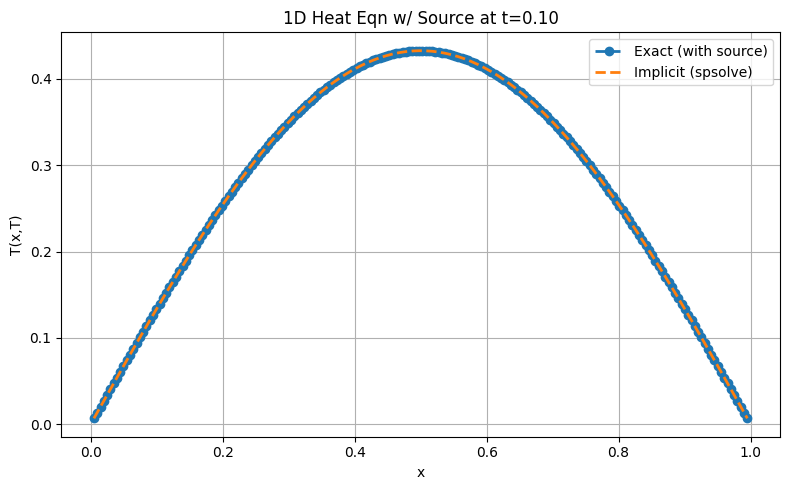

In [10]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# -----------------------------------------------
# 1) PARAMETERS & GRID
# -----------------------------------------------
L, α, k = 1.0, 1.0, 1.0
T_final = 0.1
N = 200
dx = L/(N+1)
x  = np.linspace(dx, L-dx, N)
dt = 0.5*dx*dx/α         # choose λ=0.5
τ  = α * dt / dx**2
steps = int(T_final / dt)

# -----------------------------------------------
# 2) SOURCE TERM
# -----------------------------------------------
def heat_source(x, t):
    return np.sin(np.pi*x) * np.exp(-t)

# -----------------------------------------------
# 3) INITIAL CONDITION
# -----------------------------------------------
u0 = np.sin(np.pi*x)

# -----------------------------------------------
# 4) IMPLICIT–MATRIX SOLVER (via spsolve)
#    solves (I - τ·A) u_{n+1} = u_n + dt·(α/k)·f^n
# -----------------------------------------------
# build sparse Laplacian A and system matrix M
main = -2*np.ones(N)
off  =  np.ones(N-1)
A    = sp.diags([off, main, off], [-1,0,1], format='csr')
I    = sp.eye(N, format='csr')
M    = I - τ*A

u_mat = u0.copy()
for n in range(steps):
    t = n*dt
    f = heat_source(x, t)
    rhs = u_mat + (dt*α/k)*f
    u_mat = spla.spsolve(M, rhs)

# -----------------------------------------------
# 5) IMPLICIT–THOMAS SOLVER (slide formula)
#    directly implements tridiagonal solve:
#
#    –τ u_{i-1}^{n+1} + (1+2τ) u_i^{n+1} –τ u_{i+1}^{n+1}
#      = u_i^n + τ·(Δx)²/k · e_gen_i^n
# -----------------------------------------------
def thomas_tridiag(a, b, c, d):
    """
    Solve a_i x_{i-1} + b_i x_i + c_i x_{i+1} = d_i
    for i=0..N-1 with a[0]=0, c[-1]=0        
    """
    n = len(d)
    # forward sweep
    cp = np.empty(n-1); dp = np.empty(n)
    cp[0] = c[0]/b[0]
    dp[0] = d[0]/b[0]
    for i in range(1,n-1):
        denom = b[i] - a[i]*cp[i-1]
        cp[i] = c[i]/denom
        dp[i] = (d[i] - a[i]*dp[i-1]) / denom
    dp[-1] = (d[-1] - a[-1]*dp[-2]) / (b[-1] - a[-1]*cp[-2])
    # back substitution
    x = np.empty(n)
    x[-1] = dp[-1]
    for i in reversed(range(n-1)):
        x[i] = dp[i] - cp[i]*x[i+1]
    return x

# set up constant tridiagonal coefficients
a = -τ * np.ones(N);  a[0] = 0.0
b =  (1+2*τ)*np.ones(N)
c = -τ * np.ones(N);  c[-1] = 0.0

u_thomas = u0.copy()
for n in range(steps):
    t = n*dt
    f = heat_source(x, t)
    d = u_thomas + τ*(dx*dx/k)*f
    u_thomas = thomas_tridiag(a, b, c, d)

# -----------------------------------------------
# 6) EXACT (manufactured) SOLUTION WITH SOURCE
# -----------------------------------------------
def A_exact(t, alpha=α):
    pi2 = np.pi**2 * alpha
    return (np.exp(-t) - np.exp(-pi2*t)) / (pi2 - 1) + np.exp(-pi2*t)

def u_exact(x, t):
    return A_exact(t) * np.sin(np.pi*x)

u_ref = u_exact(x, T_final)

# -----------------------------------------------
# 7) ERROR ANALYSIS
# -----------------------------------------------
def rel_error(u_num, u_ref):
    return np.linalg.norm(u_num-u_ref)/np.linalg.norm(u_ref)

print("RelError (matrix):", rel_error(u_mat,   u_ref))
print("RelError (Thomas):",rel_error(u_thomas,u_ref))

# -----------------------------------------------
# 8) PLOTTING ALL THREE
# -----------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(x, u_ref,    'o--', color='tab:blue',  lw=2, label='Exact (with source)')
plt.plot(x, u_mat,    'k--', color='tab:orange', lw=2, label='Implicit (spsolve)')
#plt.plot(x, u_thomas, 's-', color='tab:green',  ms=4, label='Implicit (Thomas)')
plt.xlabel('x')
plt.ylabel('T(x,T)')
plt.title(f'1D Heat Eqn w/ Source at t={T_final:.2f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Relative L2 error: 8.56e-05
Maximum absolute error: 3.70e-05


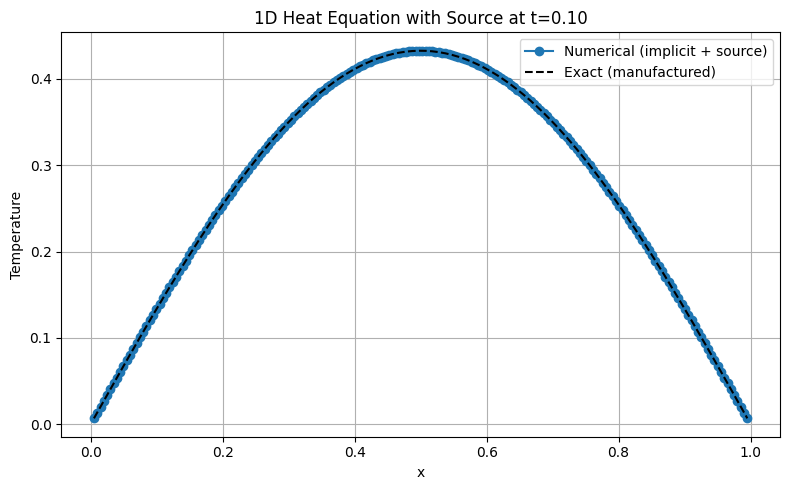

In [3]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# -----------------------------------------------
# 1) PARAMETERS & GRID SETUP
# -----------------------------------------------
L, alpha, k = 1.0, 1.0, 1.0      # rod length, diffusivity, conductivity
T = 0.1                          # final time
N = 200                          # number of interior points
dx = L / (N + 1)                 # spatial step
x = np.linspace(dx, L - dx, N)   # interior grid points
dt = 0.5 * dx * dx / alpha       # time step (λ = 0.5 for stability)
r = alpha * dt / dx**2           # CFL-like number
steps = int(T / dt)              # number of time steps

# -----------------------------------------------
# 2) SPARSE MATRIX ASSEMBLY (Laplacian)
# -----------------------------------------------
main_diag = -2 * np.ones(N)
off_diag  =  np.ones(N - 1)
A = sp.diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csr')
I = sp.eye(N, format='csr')
M = I - r * A   # system matrix for implicit scheme

# -----------------------------------------------
# 3) SOURCE TERM DEFINITION
# -----------------------------------------------
def heat_source(x, t):
    """
    Internal heat generation rate: sin(pi x) * exp(-t)
    Units: W/m^3 (normalized by k later)
    """
    return np.sin(np.pi * x) * np.exp(-t)

# -----------------------------------------------
# 4) INITIAL CONDITION
# -----------------------------------------------
u = np.sin(np.pi * x)   # initial temperature profile: pure sine mode

# -----------------------------------------------
# 5) TIME-STEPPING LOOP (IMPLICIT EULER + SOURCE)
# -----------------------------------------------
for n in range(steps):
    t = n * dt
    f = heat_source(x, t)                # source vector at current time
    rhs = u + (dt * alpha / k) * f       # right-hand side including source
    u = spla.spsolve(M, rhs)             # solve (I - rA) u_next = rhs

# -----------------------------------------------
# 6) EXACT SOLUTION FOR SOURCE-DRIVEN PROBLEM
# -----------------------------------------------
def A_exact(t):
    """
    Amplitude function for the manufactured exact solution
    u_exact(x,t) = A_exact(t) * sin(pi x)
    Solves A' + pi^2 A = exp(-t), A(0)=1
    """
    pi2 = np.pi**2
    C = (pi2 - 1) / (pi2 - 1)  # simplifies to 1
    # solve ODE: A(t) = C*exp(-pi2*t) + [exp(-t)-exp(-pi2*t)]/(pi2 - 1)
    return (1 / (pi2 - 1)) * (np.exp(-t) - np.exp(-pi2 * t)) + np.exp(-pi2 * t)

def u_exact(x, t):
    """Exact temperature profile at time t"""
    return A_exact(t) * np.sin(np.pi * x)

u_ref = u_exact(x, T)

# -----------------------------------------------
# 7) ERROR ANALYSIS
# -----------------------------------------------
rel_L2_error = np.linalg.norm(u - u_ref) / np.linalg.norm(u_ref)
max_abs_error = np.max(np.abs(u - u_ref))
print(f"Relative L2 error: {rel_L2_error:.2e}")
print(f"Maximum absolute error: {max_abs_error:.2e}")

# -----------------------------------------------
# 8) PLOTTING RESULTS
# -----------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(x, u,    'o-', label='Numerical (implicit + source)')
plt.plot(x, u_ref,'k--', label='Exact (manufactured)')
plt.title(f'1D Heat Equation with Source at t={T:.2f}')
plt.xlabel('x')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27768\3855434089.py:46: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  u_cg, info = spla.cg(M, u_cg, tol=1e-10, maxiter=1000)


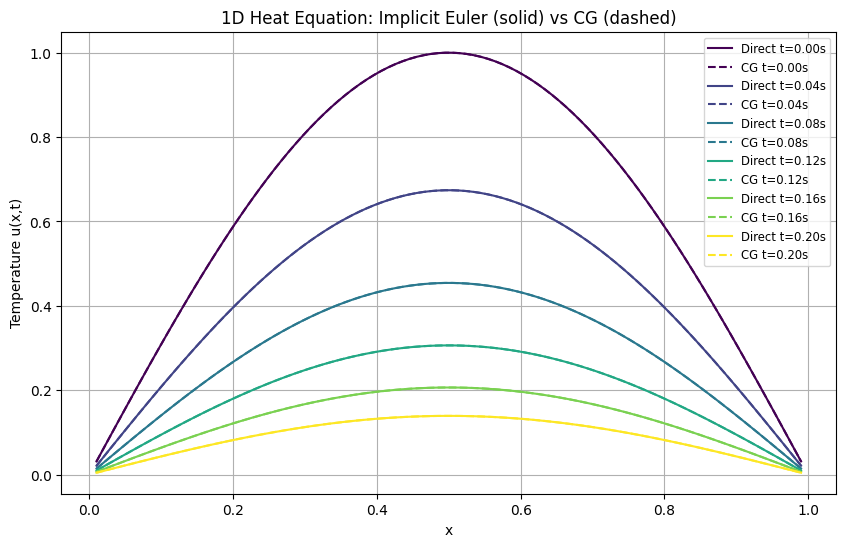

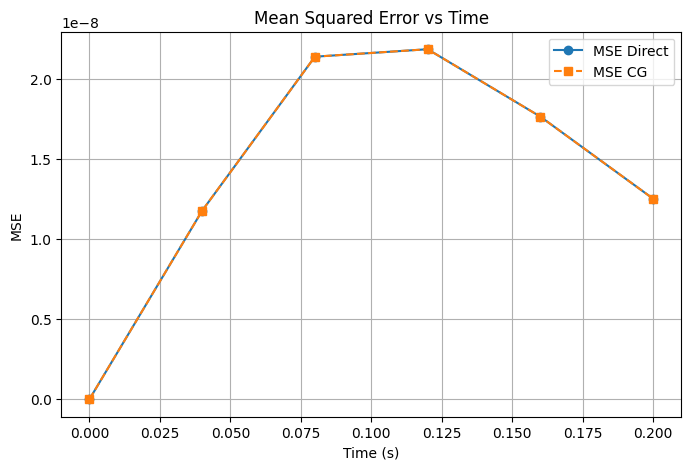

Time (s) | MSE Direct       | MSE CG
-----------------------------------------
  0.00   | 0.000e+00 | 0.000e+00
  0.04   | 1.176e-08 | 1.176e-08
  0.08   | 2.137e-08 | 2.137e-08
  0.12   | 2.184e-08 | 2.184e-08
  0.16   | 1.763e-08 | 1.763e-08
  0.20   | 1.251e-08 | 1.251e-08


In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Parameters
L = 1.0             # domain length
T = 0.2             # total time
alpha = 1.0         # thermal diffusivity
N = 100             # number of interior points
dx = L / (N + 1)    # spatial step
dt = 1e-4           # time step
r = alpha * dt / dx**2

# Grid and time setup
x = np.linspace(dx, L - dx, N)
num_steps = int(T / dt)
num_plots = 6
snap_interval = num_steps // (num_plots - 1)

# Construct sparse matrix A for second-derivative
main_diag = -2 * np.ones(N)
off_diag = np.ones(N - 1)
A = sp.diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csr')

# Left-hand side matrix M = I - r*A
I = sp.eye(N, format='csr')
M = I - r * A

# Initial condition u(x,0) = sin(pi x)
u0 = np.sin(np.pi * x)
u_direct = u0.copy()
u_cg = u0.copy()

# Storage for snapshots
times = [i * snap_interval * dt for i in range(num_plots)]
u_snap_direct = [u_direct.copy()]
u_snap_cg = [u_cg.copy()]

# Time-stepping
for step in range(1, num_steps + 1):
    # Direct solve (Implicit Euler)
    u_direct = spla.spsolve(M, u_direct)
    # Conjugate Gradient solve
    u_cg, info = spla.cg(M, u_cg, tol=1e-10, maxiter=1000)
    
    # store snapshots
    if step % snap_interval == 0:
        u_snap_direct.append(u_direct.copy())
        u_snap_cg.append(u_cg.copy())

# Theoretical solution function
def u_theoretical(x, t):
    return np.sin(np.pi * x) * np.exp(-np.pi**2 * alpha * t)

# Compute MSE at each snapshot
mse_direct = []
mse_cg = []
for t, ud, uc in zip(times, u_snap_direct, u_snap_cg):
    u_th = u_theoretical(x, t)
    mse_direct.append(np.mean((ud - u_th)**2))
    mse_cg.append(np.mean((uc - u_th)**2))

# === Superimposed Plot ===
plt.figure(figsize=(10, 6))
colors = cm.viridis(np.linspace(0, 1, num_plots))

for idx, color in enumerate(colors):
    plt.plot(x, u_snap_direct[idx], color=color, linestyle='-', label=f'Direct t={times[idx]:.2f}s')
    plt.plot(x, u_snap_cg[idx], color=color, linestyle='--', label=f'CG t={times[idx]:.2f}s')

plt.title("1D Heat Equation: Implicit Euler (solid) vs CG (dashed)")
plt.xlabel("x")
plt.ylabel("Temperature u(x,t)")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.show()

# === MSE Comparison Plot ===
plt.figure(figsize=(8, 5))
plt.plot(times, mse_direct, 'o-', label='MSE Direct')
plt.plot(times, mse_cg, 's--', label='MSE CG')
plt.title("Mean Squared Error vs Time")
plt.xlabel("Time (s)")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

# === Print MSE Table ===
print("Time (s) | MSE Direct       | MSE CG")
print("-----------------------------------------")
for t, md, mc in zip(times, mse_direct, mse_cg):
    print(f"{t:6.2f}   | {md:.3e} | {mc:.3e}")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27768\834481568.py:54: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  u_cg, _ = spla.cg(M, u_cg, tol=1e-10)


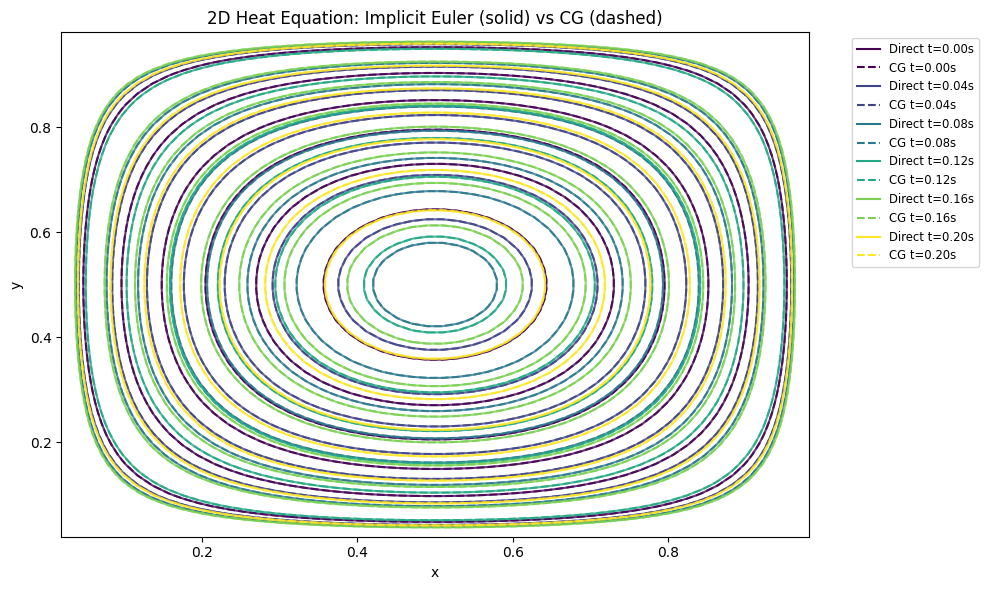

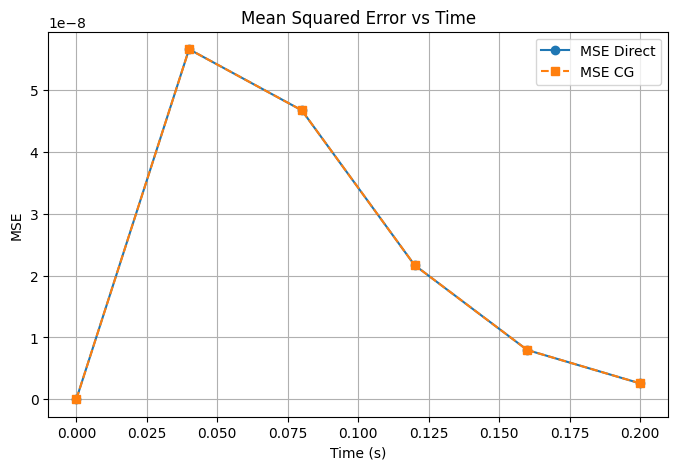

Time (s) | MSE Direct       | MSE CG
-----------------------------------------
  0.00   | 0.000e+00 | 0.000e+00
  0.04   | 5.666e-08 | 5.666e-08
  0.08   | 4.677e-08 | 4.677e-08
  0.12   | 2.172e-08 | 2.172e-08
  0.16   | 7.967e-09 | 7.967e-09
  0.20   | 2.569e-09 | 2.569e-09


In [4]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines

# Parameters (as before)
Lx, Ly = 1.0, 1.0
T = 0.2
alpha = 1.0
Nx, Ny = 50, 50
dx, dy = Lx/(Nx+1), Ly/(Ny+1)
dt = 1e-4
r_x = alpha*dt/dx**2
r_y = alpha*dt/dy**2

# Grid
x = np.linspace(dx, Lx-dx, Nx)
y = np.linspace(dy, Ly-dy, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Time stepping setup
num_steps = int(T/dt)
num_plots = 6
snap_interval = num_steps // (num_plots-1)
times = [i * snap_interval * dt for i in range(num_plots)]

# Build 2D Laplacian and implicit Euler matrix M (as before)
diag_x = np.ones(Nx)*(-2)
off_x = np.ones(Nx-1)
L1D_x = sp.diags([off_x, diag_x, off_x], [-1,0,1], format='csr')
diag_y = np.ones(Ny)*(-2)
off_y = np.ones(Ny-1)
L1D_y = sp.diags([off_y, diag_y, off_y], [-1,0,1], format='csr')
I_x = sp.eye(Nx, format='csr')
I_y = sp.eye(Ny, format='csr')
L2D = (sp.kron(L1D_x, I_y) / dx**2) + (sp.kron(I_x, L1D_y) / dy**2)
I2D = sp.eye(Nx*Ny, format='csr')
M = I2D - dt*alpha*L2D

# Initial condition
u0 = np.sin(np.pi*X) * np.sin(np.pi*Y)
u_direct = u0.flatten()
u_cg = u_direct.copy()

# Storage for snapshots
u_snap_direct = [u_direct.copy()]
u_snap_cg = [u_cg.copy()]

# Time stepping
for step in range(1, num_steps+1):
    u_direct = spla.spsolve(M, u_direct)
    u_cg, _ = spla.cg(M, u_cg, tol=1e-10)
    if step % snap_interval == 0:
        u_snap_direct.append(u_direct.copy())
        u_snap_cg.append(u_cg.copy())

# === Superimposed Contour Plot with Legend ===
plt.figure(figsize=(10, 6))
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plot contours for each snapshot
for idx, color in enumerate(colors):
    # Direct solver: solid lines
    plt.contour(
        x, y, u_snap_direct[idx].reshape(Nx, Ny),
        levels=8, colors=[color], linestyles='-', alpha=0.8
    )
    # CG solver: dashed lines
    plt.contour(
        x, y, u_snap_cg[idx].reshape(Nx, Ny),
        levels=8, colors=[color], linestyles='--', alpha=0.8
    )

# Create proxy artists for legend
handles = []
for idx, color in enumerate(colors):
    handles.append(
        mlines.Line2D([], [], color=color, linestyle='-', label=f'Direct t={times[idx]:.2f}s')
    )
    handles.append(
        mlines.Line2D([], [], color=color, linestyle='--', label=f'CG t={times[idx]:.2f}s')
    )

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("2D Heat Equation: Implicit Euler (solid) vs CG (dashed)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()



# === MSE Comparison Plot ===
plt.figure(figsize=(8, 5))
plt.plot(times, mse_direct, 'o-', label='MSE Direct')
plt.plot(times, mse_cg, 's--', label='MSE CG')
plt.title("Mean Squared Error vs Time")
plt.xlabel("Time (s)")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

# === Print MSE Table ===
print("Time (s) | MSE Direct       | MSE CG")
print("-----------------------------------------")
for t, md, mc in zip(times, mse_direct, mse_cg):
    print(f"{t:6.2f}   | {md:.3e} | {mc:.3e}")
